# Thư viện


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import wordninja
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Đọc dữ liệu

In [2]:
df_train = pd.read_csv('./Data/train_data.csv')
df_test = pd.read_csv('./Data/test_data.csv')

# Cài đặt tùy chọn hiển thị
pd.set_option('display.max_colwidth', None)




Thêm tên cột

In [3]:
df_train.columns = ['label', 'title', 'text']
df_test.columns = ['label', 'title', 'text']


Ghép 2 cột

In [4]:
def concat_columns(df, col1, col2, new_col):
    df[new_col] = df[col1].apply(str) + ' ' + df[col2].apply(str)
    df.drop(col2, axis = 1, inplace = True)
    return df

df_train = concat_columns(df_train, 'text', 'title', 'text')
df_test = concat_columns(df_test, 'text', 'title', 'text')

Đổi nhãn

In [5]:
df_train['label'] = df_train['label'].map({1:0, 2:1})
df_test['label'] = df_test['label'].map({1:0, 2:1})

In [6]:
df_train

,label,text
0,1,"My son got this toy for his birthday. The kids had a lot of fun with it that first night. By the next day one of the ears had broken off. When he went to play with it, several days later, the thing would not work at all. Batteries were changed and reset button pushed, still nothing. .... Very disappointed"
1,0,A person I work with highly recommended it. He said he solved his mole problem with his tulips. It may work for the smaller critters but did not help with my dog or cat. I sprinkled it all around my vegetable garden and my dog didn't even notice it and I used the whole big bottle. The day after I sprinkled it the cat was sitting right in the midst of it. Doesn't help with cats or dogs!
2,0,This DVD is real old school and cheezeball. Bad quality because of the date it was created and doesn't even come close to anything created in the last 20 years for kids. Very very bad dvd! It looks as though a 10 yr old artist made this. Characters do not talk - it is a man's voice telling the story in the background. Don't waste your money on this DVD
3,0,"Mr. Spong has attempted to reduce God to base ""human terms."" His focus is on the creature and not the creator. God's wrath against sin is as secure a part of his character as is his love. You can NEVER seperate the two. Ezekiel 13 describes the false prophets who cry ""All is well!"" All is not well. Billions face a Christless eternity in hell. Spong provides a sliding board to begin the descent. Repent and believe in Jesus and thou shalt be saved. Do not follow Spong or any other like him. Follow Jesus! EZEKIEL 13"
4,0,"I am the fourth review and the third to complain that the tray bezel won't fit my computer case. The tray won't even open because the idiots at Pioneer decided to make the front of the tray be as big as the entire drive! Very poor engineering. I wish that I could tell you how it performs but I have to take it back without even getting a chance to see the tray open. And the worst part of it is that there was absolutely no need for the drive to be designed this way. They were simply trying to make it look ""pretty"". Fools... they are going to be getting a lot of drives returned. Won't fit your case."
...,...,...
299995,0,"First off, the box says Win98SE compatible, yet LOMAC does NOT work on Win98SE for me and for everybody else that I have read on the flight sim forums. It is inconceivable that it was released like this. I also have a XP multi-boot which it does run on. Now for the really bad news. This game has so many bugs, it will be a LONG time before humpty dumpty is fixed and when 6 Ghz machines exist (see below). No dynamic campaign and No printed manual included either. The .pdf manual on disk is poor which is why this game has a steep learning curve. I have a high end 3.2Ghz, 512MB, MSI GeForce 5900 256MB machine and the frame rates stink. The best I get is 20-25fps (at medium detail!!) with little air activity, so those with mid or low end machines best forget this game! There are much better flight sims than LOMAC made in the past 5 years that work, are fun, run great, so I suggest to all to stick with those. Not Recommended, Not Fun, Too Many Bugs"
299996,1,Awesome for anybody looking to laugh hard! A bunch of nerds butting heads and making fun of each other. A must see! Big Bang Theory Season 4
299997,0,"I have purchased 2 """"NeverKink"" brand hoses in the past, and both were constantly getting kinked. I finally threw the first one in the trash after several years. The second one I still use, but it kinks every time I pull it. I'm on Amazon today looking for a different brand of hose, and couldn't believe that this bad hose had some 5 star ratings? I have not had one explode, but buy this hose at your own risk. It will kink, guaranteed! Always kink hose"
299998,1,"I've been using these for a little less than a month. The grip is comfortable, and they are durable and don't slide around on the ground. They are smaller and not as ""ratt

# Phân tích dữ liệu

Có bao nhiêu hàng rỗng

In [7]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

label    0
text     0
dtype: int64
label    0
text     0
dtype: int64


Biểu đồ số nhãn

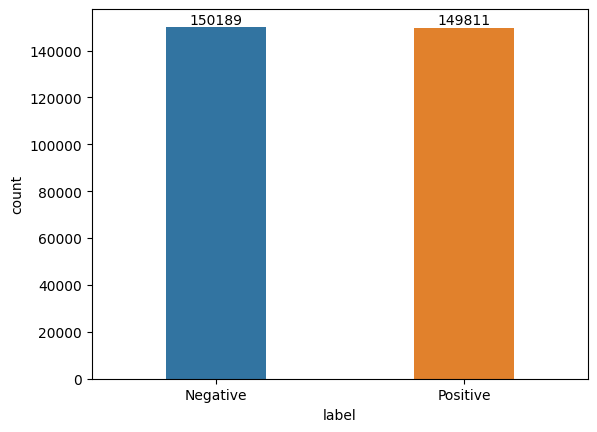

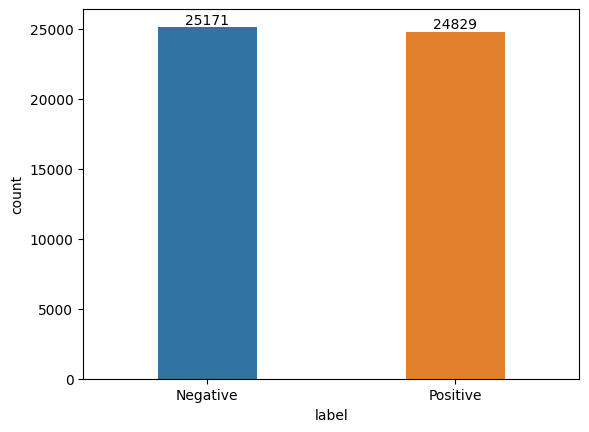

In [8]:
def draw_plt(data):
  sns.countplot(data, x='label', width=0.4)
  ax = plt.gca()
  ax.set_xticklabels(['Negative', 'Positive'])
  plt.ylabel("count")
  for label in ax.containers:
    ax.bar_label(label)
  plt.show()

draw_plt(df_train)
draw_plt(df_test)

Kiểm tra những hàng chứa emoji icon

In [9]:
def check_for_emoji(data):
    df = data.astype(str)
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )

    def contains_emoji(text):
        emojis = emoji_pattern.findall(text)
        return len(emojis) > 0

    contains_emoji_rows = df.applymap(contains_emoji).any(axis=1)
    rows_with_emoji = df[contains_emoji_rows]

    return rows_with_emoji

data={
    'text': ["I love ❤️ OpenAI! 😃🚀",
             "edbhfdbh dfndsjndnjf",
             "dfhdfhdhndfhndjfnjndf",
             "dhdhdh luv"],
    'tex': ["I love ",
             "edbhfdbh ❤️ dfndsjndnjf",
             "dfhdfhdhndfhndjfnjndf",
             "dhdhdh dsbúdbds"]
}
df = pd.DataFrame(data)
check_for_emoji(df)

,text,tex
0,I love ❤️ OpenAI! 😃🚀,I love
1,edbhfdbh dfndsjndnjf,edbhfdbh ❤️ dfndsjndnjf


In [10]:
check_for_emoji(df_train)

,label,text
157844,1,i built my own headset im 12 today (...)resets by itself for some reason i dont know why but it ROX♦ fun
250465,1,"Well.. I saw this one, before the ""original"". :) so.. for me, I liked this one better :) Elizabeth Perkins is beautiful and unlike the original movie character, she has a bit more softness to her, which I found beautiful.The little girl who played her daughter was wonderful too. Actually the whole cast was :)Definitely worth the money, and don't forget the original. I liked that one, but I loved this one ♥. Excellent"


In [11]:
check_for_emoji(df_test)

,label,text


Biểu đồ tần suất theo độ dài của câu

In [12]:
def plot_text_length(data):
    text_length = pd.Series([len(review.split()) for review in data])

    plt.figure(figsize=(20, 12))
    sns.histplot(text_length, palette="deep")
    plt.xlabel("Text Length")
    plt.ylabel("Frequency")
    plt.title("Histogram of Text Length")
    plt.show()

C:\Users\Mai Vu Duy\AppData\Local\Temp\ipykernel_15364\2744452014.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(text_length, palette="deep")


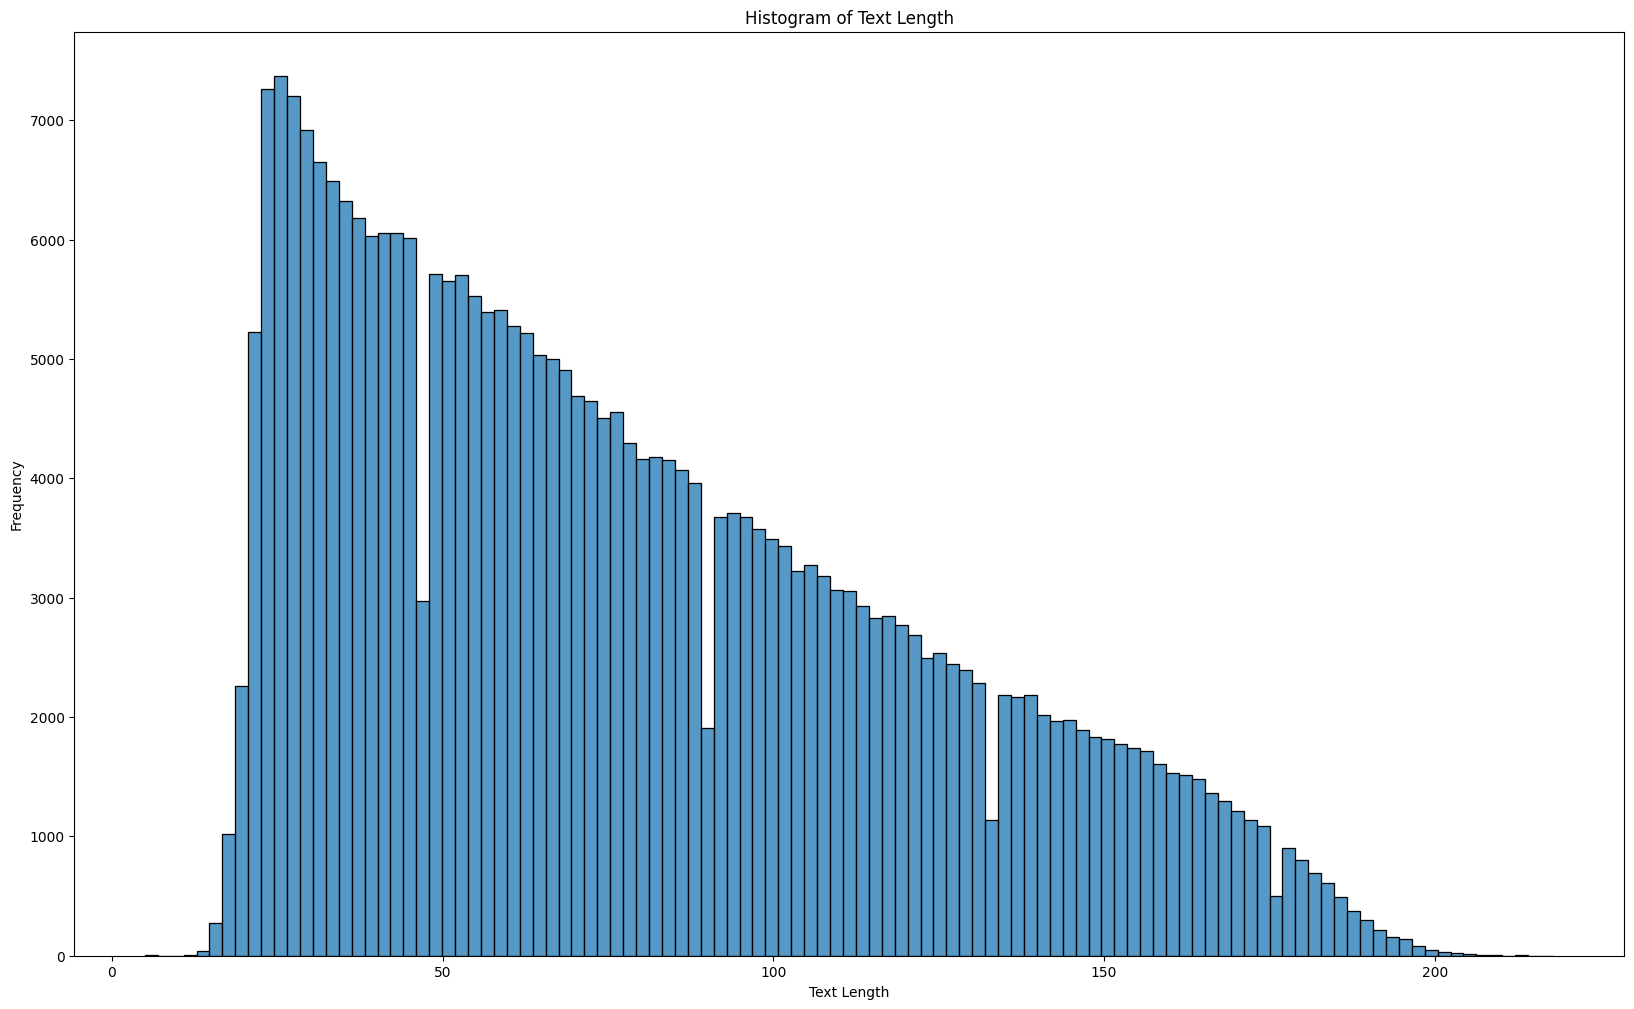

In [13]:
plot_text_length(df_train["text"])

# Tiền xử lí dữ liệu

Thay thế từ viết tắt, sai chính tả

In [14]:
def fix_slang_and_typos(text):
  text = re.sub(r'omg','oh my god',text)
  text = re.sub(r'FYI','for your information',text)
  text = re.sub(r'IDK',"I don't know",text)
  text = re.sub(r'OMG','oh my god',text)
  text = re.sub(r'thx','thanks',text)
  text = re.sub(r'LOL','laugh out loud',text)
  text = re.sub(r'WTF','what the fuck',text)
  return text
print(fix_slang_and_typos("omg, I'm so LOL. IDK what to do. FYI, I'm gonna be late. thx for understanding!"))


oh my god, I'm so laugh out loud. I don't know what to do. for your information, I'm gonna be late. thanks for understanding!


In [15]:
# Applying the function
df_train['text'] = df_train['text'].apply(fix_slang_and_typos)
df_test['text'] = df_test['text'].apply(fix_slang_and_typos)

In [16]:

nltk.download('stopwords')
stopwords_list = stopwords.words('english')
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to C:\Users\Mai Vu
[nltk_data]     Duy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Làm sạch dữ liệu

In [17]:

def clean_text(text):
     # Loại bỏ các thẻ HTML
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text(separator=" ")

    # Loại bỏ kí tự đặc biệt, chữ và số
    text = re.sub(r'[^A-Za-zÀ-ú ]+', ' ', text)

    # Chuyển đổi thành chữ thường
    text = text.lower()

    # Trả lại  các từ viết dính nhau
    text = ' '.join(wordninja.split(text))

    # Loại bỏ các từ stopword
    words = text.split()
    words = [word for word in words if word not in stopwords_list]
    text = ' '.join(words)

    # Loại bỏ khoảng trống thừa
    text = re.sub(r'\s+', ' ', text).strip()


    return text


html_text = "I'm very beautiful acc america dog  wordonword. .f..f.f. </html>"

text = clean_text(html_text)
print(text)


beautiful acc america dog word word f f f


In [18]:
# Applying the function
df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

C:\Users\Mai Vu Duy\AppData\Local\Temp\ipykernel_15364\518359222.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\Mai Vu Duy\AppData\Local\Temp\ipykernel_15364\518359222.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


Stemmer

In [24]:

def stemmer_text(text):
    stemmer = SnowballStemmer("english")
    normalized_text = []
    for word in text.split():
        stemmed_word = stemmer.stem(word)
        normalized_text.append(stemmed_word)
    return ' '.join(normalized_text)

# Ví dụ sử dụng
text = "I am running and changing"
normalized_text = stemmer_text(text)
print(normalized_text)


i am run and chang


In [25]:
# Applying the function
df_train['text'] = df_train['text'].apply(stemmer_text)
df_test['text'] = df_test['text'].apply(stemmer_text)

In [26]:
df_train

,label,text
0,1,son got toy birthday kid lot fun first night next day one ear broken went play sever day later thing would work batteri chang reset button push still noth disappoint
1,0,person work high recommend said solv mole problem tulip may work smaller critter help dog cat sprinkl around veget garden dog even notic use whole big bottl day sprinkl cat sit right midst help cat dog
2,0,dvd real old school che eze ball bad qualiti date creat even come close anyth creat last year kid bad dvd look though yr old artist made charact talk man voic tell stori background wast money dvd
3,0,mr pong attempt reduc god base human term focus creatur creator god wrath secur part charact love never seper two ezekiel describ fals prophet cri well well billion face christ less etern hell pong provid slide board begin descent repent believ jesus thou shalt save follow pong like follow jesus ezekiel
4,0,fourth review third complain tray z el fit comput case tray even open idiot pioneer decid make front tray big entir drive poor engin wish could tell perform take back without even get chanc see tray open worst part absolut need drive design way simpli tri make look pretti fool go get lot drive return fit case
...,...,...
299995,0,first box say win se compat yet loma c work win se everybodi els read flight sim forum inconceiv releas like also xp multi boot run realli bad news game mani bug long time humpti dumpti fix ghz machin exist see dynam campaign print manual includ either pdf manual disk poor game steep learn curv high end ghz mb msi geforc mb machin frame rate stink best get fps medium detail littl air activ mid low end machin best forget game much better flight sim loma c made past year work fun run great suggest stick recommend fun mani bug
299996,1,awesom anybodi look laugh hard bunch nerd but head make fun must see big bang theori season
299997,0,purchas never kink brand hose past constant get kink final threw first one trash sever year second one still use kink everi time pull amazon today look differ brand hose believ bad hose star rate one explod buy hose risk kink guarante alway kink hose
299998,1,use littl less month grip comfort durabl slide around ground smaller rattl push bar multipl part great product great push bar


Lưu lại data sau khi tiền xử lí

In [27]:
df_train.to_csv('https://drive.google.com/uc?id=12CFIKseAi69Wx5gENMdlhXwBDA-NEJEQ',index=False)
df_test.to_csv('https://drive.google.com/uc?id=1n-ErlpIG5BidD_dFoYG01hUY9QkCbciQ',index=False)

Biểu đồ đám mây tần suất các từ sau tiền xử lí dữ liệu

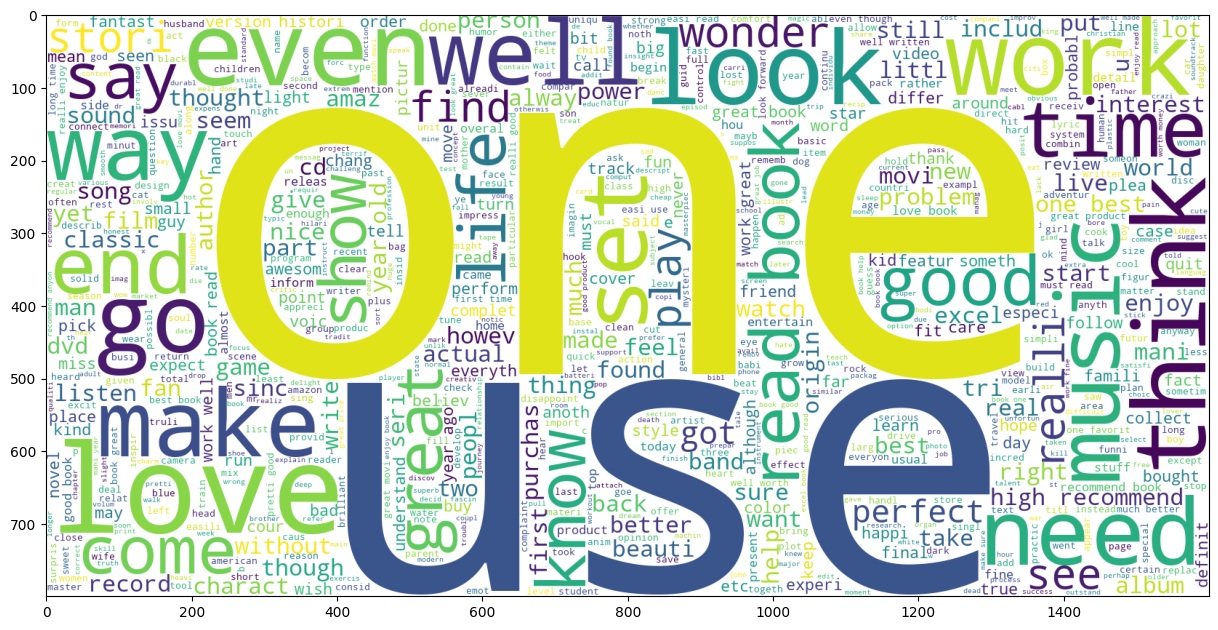

In [29]:
# Positive Label WordCloud
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600,
               background_color="white").generate(" ".join(df_train[df_train["label"]==1].text))
plt.imshow(wc)

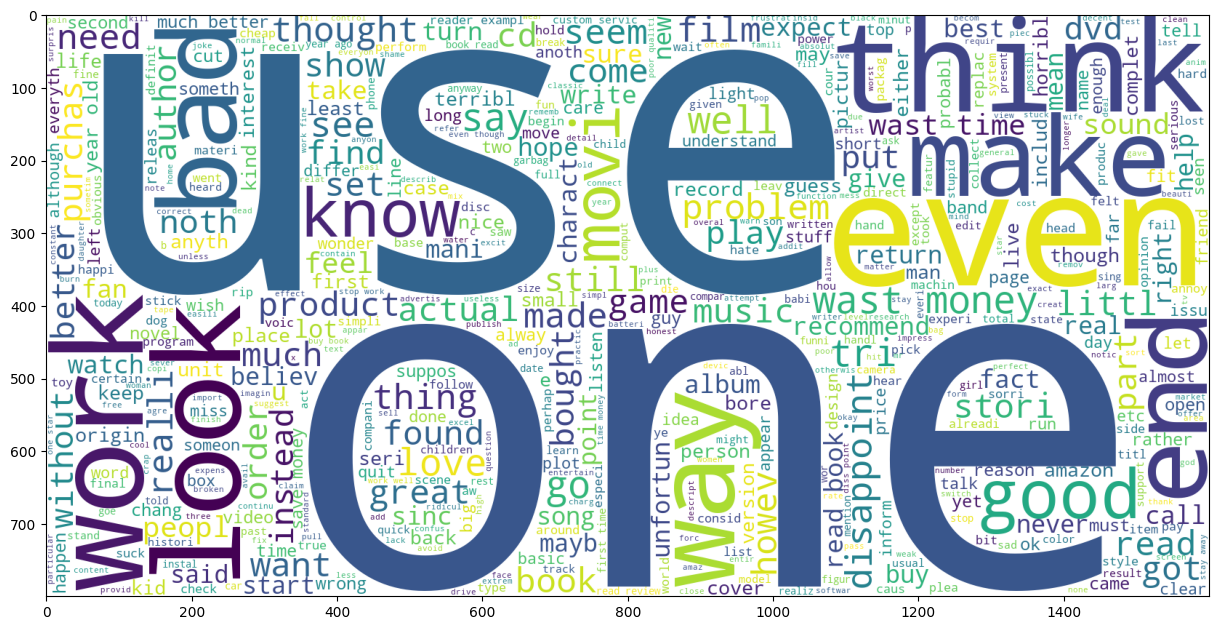

In [30]:
# Negative Label WordCloud
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600,
               background_color="white").generate(" ".join(df_train[df_train["label"]==0].text))
plt.imshow(wc)

# Vector hóa dữ liệu

In [31]:

# Khởi tạo TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit và transform dữ liệu train
X_train = vectorizer.fit_transform(df_train['text'])

# Transform dữ liệu test
X_test = vectorizer.transform(df_test['text'])

In [32]:
Y_train= df_train['label'].to_numpy()
Y_test= df_test['label'].to_numpy()

In [33]:
print(X_train.shape)
print(X_test.shape)

(300000, 45390)
(50000, 45390)


In [34]:
print(X_train[0])

  (0, 10643)	0.14169776532541575
  (0, 27829)	0.16066545237572655
  (0, 38239)	0.14085593839365904
  (0, 31979)	0.23065622412129363
  (0, 5609)	0.22318926249033996
  (0, 33359)	0.2811128348175455
  (0, 6739)	0.17766508954656554
  (0, 3245)	0.19677947707158824
  (0, 44560)	0.1106318029456142
  (0, 44617)	0.10401281530937302
  (0, 40127)	0.13416124986430913
  (0, 22253)	0.2016157606157929
  (0, 35849)	0.1768915596321869
  (0, 30661)	0.14686127128468154
  (0, 43957)	0.18410300333357615
  (0, 5134)	0.22253900799131285
  (0, 11723)	0.22286278736548032
  (0, 28436)	0.08722533904143957
  (0, 9734)	0.2898243257755821
  (0, 27346)	0.1762749197890589
  (0, 27468)	0.19598800979159137
  (0, 13988)	0.12218104047511456
  (0, 14915)	0.16747070310567735
  (0, 23344)	0.14325161447847035
  (0, 21318)	0.17665156832841764
  (0, 4027)	0.24642631812148835
  (0, 40815)	0.2055385297272876
  (0, 16188)	0.1405636975687778
  (0, 37333)	0.18912472812679482


# Train Model


Tìm kiếm tham số thích hợp cho mô hình

In [35]:

# Create the LinearSVC model
svm_model = LinearSVC(tol=1e-4)

# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.05, 0.1, 1.0, 10.0],

}

# Perform grid search
grid_search = GridSearchCV(svm_model, param_grid, cv=5,scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)


c:\Users\Mai Vu Duy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Mai Vu Duy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Mai Vu Duy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Mai Vu Duy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.

Best parameters: {'C': 0.1, 'penalty': 'l2'}


Huấn luyện mô hình

In [44]:
# Create a new model with the best parameters
best_svm_model = LinearSVC(
    C=best_params['C'],
    penalty=best_params['penalty'],
    tol=1e-4

)

# Train the model with the best parameters
best_svm_model.fit(X_train, Y_train)

c:\Users\Mai Vu Duy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=0.1, tol=1e-05)

# Đánh giá mô hình

In [45]:
# Đánh giá mô hình
pred = best_svm_model.predict(X_test)
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     25171
           1       0.88      0.89      0.88     24829

    accuracy                           0.88     50000
   macro avg       0.88      0.88      0.88     50000
weighted avg       0.88      0.88      0.88     50000



Confusion matrix

In [39]:
print("Confusion matrix: \n", confusion_matrix(Y_test,pred))

Confusion matrix: 
 [[22150  3021]
 [ 2835 21994]]


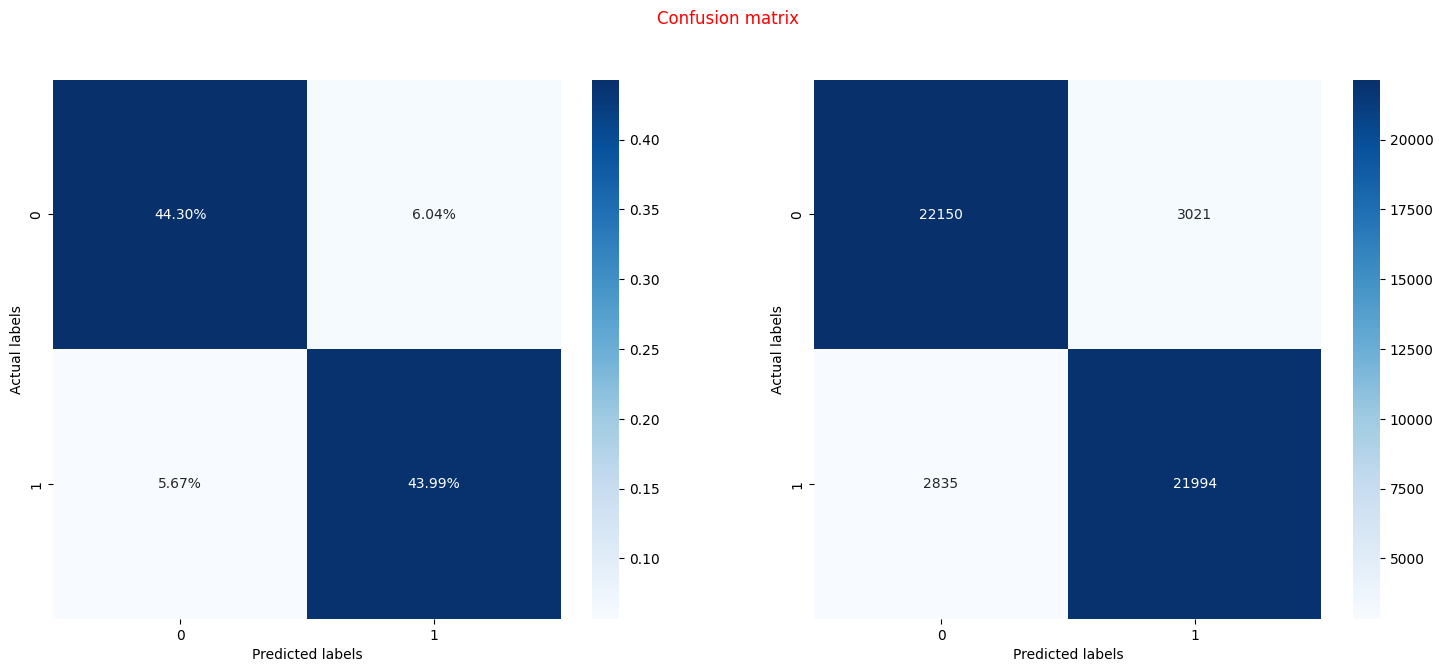

In [40]:
conf_mx = confusion_matrix(Y_test,pred)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('Confusion matrix', c='r')

sns.heatmap(conf_mx/np.sum(conf_mx), ax=axes[0], annot=True,
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('Actual labels')

sns.heatmap(conf_mx, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('Actual labels')
plt.show()

In [46]:
print("Accuracy: ", 100* accuracy_score(Y_test,pred),"%")

Accuracy:  88.288 %
